# Project 2
## Eniacs product strategy

Your analyse can finally settle an ongoing debate for the mgmt: whether or not it’s beneficial to discount products.

*Pro discount*\
Marketing Team Lead is convinced that offering discounts is beneficial in the long run:
1. discounts improve customer acquisition, satisfaction and retention, and allows the company to grow.

*Con discount*\
Main investors in the Board are worried about offering aggressive discounts:
1. recent quarterly results showed an increase in number of orders, but a decrease in the total revenue
2. focus in quality segment, rather than offer lowest prices in market

*Your analytical and business skills are needed to give clarity in the following aspects:*
- How products should be classified into different categories in order to simplify reports and analysis.
- What is the distribution of product prices across different categories.
- How many products are being discounted.
- How big are the offered discounts as a percentage of the product prices.
- How seasonality and special dates (Christmas, Black Friday) affect sales.
- How could data collection be improved.

`Present to company board your analysis (short and concise, but also engaging and convincing)`

## Brainstorming

Investigation and creating diagrams: 
1. ratio of discount products to monthly revenue --> Mahsa
2. qty of high-end products to monthly revenue --> Rias
3. Which are top products? (may be this question can be included to question no 4)
4. Categories --> Kristina
- NAS/ HDD
- Computer
- Phones
- Monitor
- Peripheries 

May be "50/50" soluation(?)
Depending on “yes” or “no” for discount product strategy:
Mix Marketing (4Ps)

product:....shape (__10579, 5), col: sku, name, desc, price, max_price_orderlines \
orders:......shape (204691, 4), col: order_id, created_date, total_paid, state \
orderlines..shape (293743, 8), col: id, id_order, product_id, product_quantity, sku, unit_price, date, total_price \
brands:......shape (____187, 2), col: short, long

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
pd.options.display.float_format = '{:.2f}'.format

In [272]:
path = 'eniac/clean/'
orderlines = pd.read_csv(path + 'orderlines_cl.csv')
orders = pd.read_csv(path + 'orders_cl.csv')
brands = pd.read_csv(path + 'brands_cl.csv')
products = pd.read_csv(path + 'products_cl.csv')

In [273]:
orders['created_date'] = pd.to_datetime(orders['created_date'])
orderlines['date'] = pd.to_datetime(orderlines['date'])

## TRY & ERROR

In [225]:
# create one table tailored for our purpose

In [209]:
df2 = (
orderlines
    .merge(orders, how='left', left_on='id_order', right_on='order_id')
    .query('state == "Completed"')
    .merge(products, how='left', left_on='sku', right_on='sku')
)
df2.drop(['id_order', 'product_id', 'sku', 'order_id', 'created_date', 'state'], axis=1, inplace=True)
df2.rename({'product_quantity':'prod_qty', 'max_price_orderlines':'max_price_ol'}, axis=1, inplace=True)
df2 = df2[['prod_qty', 'unit_price', 'total_price', 'total_paid', 'price', 'max_price_ol', 'name', 'desc', 'date']]
df2.head(2) #62103 rows

,prod_qty,unit_price,total_price,total_paid,price,max_price_ol,name,desc,date
0,1,47.49,47.49,51.48,60.99,NaN,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,2017-01-01 01:46:16
1,1,18.99,18.99,18.99,22.95,NaN,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,2017-01-01 01:50:34


In [226]:
# distinguish between cheap and expensive "quality" products

In [216]:
df2["unit_price_cat"] = pd.cut(df2["unit_price"], 
                      bins = [0, 1000, 8500], 
                      labels=["cheap", "quality"])

In [217]:
df2.head(2)

,prod_qty,unit_price,total_price,total_paid,price,max_price_ol,name,desc,date,unit_price_cat
0,1,47.49,47.49,51.48,60.99,NaN,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,2017-01-01 01:46:16,cheap
1,1,18.99,18.99,18.99,22.95,NaN,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,2017-01-01 01:50:34,cheap


In [ ]:
p_df2 = (
df2
    .assign(year = df2['date'].dt.strftime('%Y'),
            month = df2['date'].dt.strftime('%m'))
    .groupby(['year', 'month'])
    .agg({'total_paid':'sum'})
    .reset_index()
    .assign(qlty_perc = lambda x: np.where(x['unit_price_cat'].str.count('quality')==1,1 - x['total_price'] / x['total_paid']*100, '0'))
)
p_df2

In [299]:
p_df2 = (
orderlines
    .merge(orders, how='left', left_on='id_order', right_on='order_id')
    .query('state == "Completed"')
    .assign(price_cat = lambda x: pd.cut(x['unit_price'], [0, 500, 8500]),
            y_m = lambda x: x['date'].dt.to_period('M'),
            week = lambda x: x['date'].dt.strftime('%W'),
            year = lambda x: x['date'].dt.strftime('%Y'))
    .groupby(['y_m','price_cat'])
    .agg(count = ('id_order','count'))
    .reset_index()
    .assign(total_count = lambda x: x.groupby('y_m')['count'].transform('sum'))
    .assign(ratio = lambda x: 100*x['count'] / x['total_count'],
            price_cat = lambda x: x['price_cat'].astype('str'))
    .query('price_cat == "(500, 8500]"')
)
p_df2

,y_m,price_cat,count,total_count,ratio
1,2017-01,"(500, 8500]",435,6814,6.38
3,2017-02,"(500, 8500]",240,2923,8.21
5,2017-03,"(500, 8500]",40,281,14.23
7,2017-04,"(500, 8500]",175,2191,7.99
9,2017-05,"(500, 8500]",273,2532,10.78
11,2017-06,"(500, 8500]",307,2178,14.10
13,2017-07,"(500, 8500]",409,4717,8.67
15,2017-08,"(500, 8500]",255,3141,8.12
17,2017-09,"(500, 8500]",409,2945,13.89
19,2017-10,"(500, 8500]",481,4150,11.59


In [ ]:
# plt.subplots(figsize=(14, 6))

# ax = sns.scatterplot(data=p_df2, x='y_m', y='ratio', hue='year', legend=None)
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])
# sns.lineplot(data=p_df2, x='y_m', y='ratio', hue='year')

# plt.legend(facecolor='white')
# plt.title('Ratio of quality products (+500 euro) on sales 17/18')
# plt.ylabel('Ratio [in %]')
# plt.xlabel('Week number')
# sns.despine()
# plt.show()

KeyError: 'ratio'

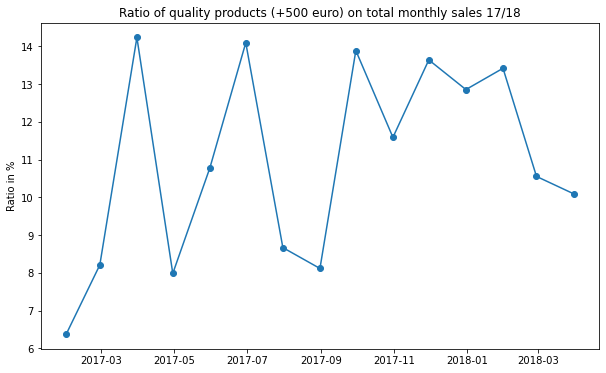

In [298]:
plt.subplots(figsize=(10, 6))

plt.plot_date(data=p_df2, x='y_m', y='ratio', linestyle='-')

plt.title('Ratio of quality products (+500 euro) on total monthly sales 17/18')
plt.ylabel('Ratio in %')
plt.ylim(0, p_df['ratio'].max()*1.2)
sns.despine()
plt.show()

In [301]:
(
orderlines
    .merge(orders, how='left', left_on='id_order', right_on='order_id')
    .query('state == "Completed"')
    .assign(price_cat = lambda x: pd.cut(x['unit_price'], [0, 1000, 8500]),
            y_m = lambda x: x['date'].dt.to_period('M'))
    .groupby(['y_m','price_cat'])
    .agg(count = ('id_order','count'))
    .reset_index()
    .assign(total_count = lambda x: x.groupby('y_m')['count'].transform('sum'))
    .assign(ratio = lambda x: x['count'] / x['total_count'],
            price_cat = lambda x: x['price_cat'].astype('str'))    
    .query('price_cat == "(1000, 8500]"')
    .to_excel('eniac/filename.xlsx')
)

In [313]:
(
orderlines
    .query('sku == "APP1922"')
    .merge(products, how='left')
    ['name']
    .head(1)
)                
    #['unit_price'].describe()
## sku – stock keeping unit: a unique identifier for each product
## amount: 1610, min: 0, max: 179, mean: 162.41, std: 11.56

0    AirPods Apple Bluetooth Headset for iPhone iPa...
Name: name, dtype: object

In [ ]:
tmp1 = (
products
    .loc[products['name'].str.contains(r'HDD','Apple')]
    .sort_values('price', ascending=False)
)
tmp1 # Monitor 272. Laptop 4, NAS 629

In [ ]:
tmp2.sort_values('total_paid', ascending=False).head(5)

In [87]:
orders_compl = orders.query('state == "Completed"')

In [ ]:
p_df = (
orders_compl
    .assign(year = orders['created_date'].dt.strftime('%Y'), 
           month = orders['created_date'].dt.strftime('%b'))
    .groupby(['year','month'])
    .agg({'total_paid':'sum'})
    .reset_index()
)
p_df

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.subplots(figsize=(12, 8))
# sns.boxplot(data=p_df, x='month', y='total_paid', hue='year', order=months)
# plt.ylim(0, 800)
p = sns.barplot(data=p_df, x='month', y='total_paid', hue='year', order=months)
p.axhline(
    p_df['total_paid'].mean(), 
    linestyle='--',
    color='gray'
)
plt.xlabel('Month')
plt.ylabel('Total paid')
plt.title('Total paid evolution through 2017 and 2018')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [ ]:
p_df = (
df
    .assign(year = orders['date'].dt.strftime('%Y')),
            month = orders['date'].dt.strftime('%m'))
    .groupby(['year', 'month'])
    .agg({'total_paid':'sum'})
    .reset_index()
    .assign(qlty_perc = lambda x: np.where(x['unit_price_cat'].str.count('quality')==1, x['total_price'], '0'
                                           round((1 - x['unit_price'] / x['price'])*100)))
            

    
    products = products.assign(new_decimals = lambda x: np.where(x['price'].str.count('\.')==0, x['price']+'00', x['price'].str.replace('\.','', regex=True)))

            disc = lambda x: x['total_paid'] - x['total_price'])
    .groupby(['year','Month','state', 'week'])
    .agg({'id_order':'count', 'total_paid':'sum', 'disc_perc':'mean'})
    .reset_index()
    .assign(week_n_orders = lambda x: x.groupby(['year','week'])['id_order'].transform('sum'))
    .assign(state_perc = lambda x: x['id_order'] / x['week_n_orders'])
    .assign(completed_state = lambda x: x['state']=='Completed')
   # .query('state == "Completed"')
)
p_df.sample(2)


In [197]:
tmp2.query('unit_price >= 1000').sort_values('unit_price', ascending=False).head(1)

,prod_qty,unit_price,total_price,total_paid,price,max_price_ol,name,desc,date
39575,1,8287.80,8287.80,8287.80,9799.00,NaN,12big LaCie Hard Disk 120TB RAID Thunderbolt 3...,12 120TB hard drive bays with RAID 5 two ports...,2017-11-26 16:02:50


In [199]:
tmp2['unit_price'].describe()

count   62103.00
mean      239.90
std       501.95
min         0.00
25%        28.99
50%        69.99
75%       185.79
max      8287.80
Name: unit_price, dtype: float64

In [ ]:
tmp2['unit_price'].value_counts()

In [ ]:
tmp2.hist(figsize=(17,12))